# 1 Author
**Student Name**: Kaushal Yadav <br>
**Student ID**: 231030364



# 2 Problem formulation
The problem I wish to address is for a machine to be able to distinguish between rice and chips, thus enabling the automation of differentiation between these two food items based on visual features.
Possible areas of application are:
1. Diet monitoring using computer vision.
1. Calorie estimation using computer vision.
1. Better and enhanced food recognition in apps like Photos in Apple devices and/or Google devices.
1. Advancing computer vision capabilities when it comes to food recognition.

As I'm sure you understand, this model would only be tackling one small brick out of an entire Rubik's Cube but as long as we are making developments on the current capabilities, we are making progress.

# 3 Machine Learning pipeline

My pipeline will essentially take an image as input and return a label, which will either be rice or chips. Do not worry, I will let you peek behind the curtian. But this will just be a sneak peek, the real thing comes in a bit later. Behind the curtain (Pipeline):
1. Preprocessing: Not all pictures are the same; we have to in some way "normalize" the pictures or rather the dimensions of the images.
    * Cropping out the unnecessary part or adding a pad along the shorter dimension between N and M in an efficient manner.
    * Resizing: Reducing the overall size of the image to the desired size, that is, choosing how much definition we need inside the image.
1. Feature extraction: Extracting the feature or set of features that help separate our model into rice and chips in n-dimensional space, where n could be anything depending upon the number of features we choose.
1. The feature vector is then passed to the trained model and -

This is where my pipeline ends, and what comes out is either 1 for "rice" or 0 for "chips".


# 4 Transformation stage

## Basic Image Transformation:
1. Padding the image to make it square without losing information.
1. Resizing the image

## Feature Extraction:
1. (Existing feature) get_yellow_component
1. (Existing features and new) GMLC_features:
    1. Dissimilarity
    1. Correlation
    1. (New) Energy
    1. (New) Entropy
1. edge_density
1. mser_features:
    1. Total number of regions
    1. get_iou_features
1. calculate_yellowness_scores
1. calculate_yellow_mser_regions
1. corner_count


# 5 Modelling

I tried out the models below:
1. Logistic Regression: It wasn't capturing comlex relationships well.
1. K-Nearest Neighbors: It wasn't good at capturing the relevance of a feature and was computationally very expensive.
1. Naive Bayes: The fact that it assumes independence made it difficult to capture dependencies between features.
1. Decision Tree: Gave 99% training accuracy with just two simple features, was very prone to overfitting. After fine tuning it became my second choice. The only problem was it's inability to address class imbalance.
1. Multi-layer Perceptron: I lacked the knowledge to fine tune the parameters and was unable to stop it from overfitting.
1. Random Forest: Same problem as decision tree, was highly prone to overfitting.

#### LinearSVC (Linear support vector machine): Final choice
Reason:
1. It was able to address the class imbalances effectively.
1. Easy implementation and effective in seperating linearly serperable features.
1. Gave the highest test accuracy.

# 6 Methodology
* The splitting of the data is done using the the pre-existing Benchmark_A column present in the dataframe, which consists the "Train" and "Test" labels.
* The train data is used for training and the test data, no surprises, for testing. The results are assessed in a simple way using the following metrics. The list starts from the most important and then slowly moves on the least:
    1. (Pre-existing) Confusion Matrix: It often helped me figure out and realise if and when I was fooling myself by creating and using a feature that had an illogical bias towards one of the classes, which happened a lot during this process of trial and error. It also made me think about and consider whether there was a class imbalance in my training and/or testing dataset.
    1. Precision and recall to further highlight any biases
    1. Test accuracy: Helped me check how well my choice of classifier and feature worked to classify "unseen" real world images with real world noise or variability, so to speak.
    3. Train accuracy: Useful for detecting instances of overfitting in the model.

# 7 Dataset
* I utilized a dataset originating from students, myself included, enrolled in the QMUL MSc FT Big Data Science course, batch of 2024. The dataset comprises features such as the diet type (vegetarian or non-vegetarian), original cuisine, specific cuisine, dish name, home or restaurant preparation, ingredients, healthiness rating (categorized and encoded), likeness rating (categorized and encoded), and a benchmark indicating whether a sample is designated for training or testing. Additionally, each sample is indexed with the name of the corresponding image, ranging from "000001.jpg" to "03250.jpg."

* Restrictions were placed on the use of the image array only, prompting me to focus on basic image transformations and various feature extraction methods. The basic preprocessing steps for all images included padding to create a square shape without losing information and resizing.

* I explore various feature extraction methods, including existing features like dissimilarity, correlation, energy, and entropy. Introducing new features such as edge density, MSER features (total regions and intersection over union), yellowness scores, MSER regions in yellow, and corner count, I found through iterative testing that yellow MSER regions was the most effective for my predictive model..

Special thanks to Nikesh Bajaj and Jesús Requena Carrión for collaborating on, creating and maintaining the mlend library below where Yummy_dataset along with a lot of other fun datasets can be found and downloaded from.<br>
More information here:
[MLEND Datasets documentation](https://mlend.readthedocs.io/en/latest/)


In [1]:
!pip install --quiet mlend --upgrade

#### Basic dependenies:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spkit as sp

from skimage import exposure
from skimage.color import rgb2hsv, rgb2gray
import skimage as ski

import mlend
from mlend import download_yummy_small, yummy_small_load, yummy_load, download_yummy

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

import cv2

Mounting the drive: <br>
Alternatively, if you prefer loading the dataset using a different method, feel free to do so.

In [3]:
from google.colab import drive
drive.mount("/content/MyDrive")

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


Dowloading the images:

In [4]:
subset = {}
datadir, FILE_ERROR = download_yummy(save_to = '/content/drive/MyDrive/Data1/MLEnd1', subset = subset,verbose=1,overwrite=False,debug_mode=True)

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|3250\3250|003250.jpg
Done!


Obtaining the map:

In [5]:
#this is sort of an unnecessary step. we don't use these anywhere.
TrainSet1, TestSet1, MAPs1 = yummy_load(datadir_main = datadir,encode_labels=True,)

Total 3250 found in /content/drive/MyDrive/Data1/MLEnd1/yummy/MLEndYD_images/


In [6]:
#reading the dataset
MLENDYD_df1 = pd.read_csv('/content/drive/MyDrive/Data1/MLEnd1/yummy/MLEndYD_image_attributes_benchmark.csv').set_index('filename')
MLENDYD_df1

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
filename,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
000002.jpg,non_vegetarian,english,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",unhealthy,2.0,like,4.0,Train
000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train
000004.jpg,vegetarian,indian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",unhealthy,2.0,strongly_like,5.0,Train
000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train
...,...,...,...,...,...,...,...,...,...,...,...
003246.jpg,vegetarian,indian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",healthy,4.0,strongly_like,5.0,Train
003247.jpg,vegetarian,indian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",healthy,4.0,strongly_like,5.0,Test
003248.jpg,vegetarian,indian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",very_unhealthy,1.0,like,4.0,Test


Let's get a general idea about how many variations we see in the names of ingredient and dishes:

In [7]:
#generating a list of all the ingredients
ingreds = [i for j in [i.split(",") for i in MLENDYD_df1.Ingredients] for i in j]
print(f"Total number of unique ingredients: {len(set(ingreds))}")
print(f"Total number of ingredients: {len(ingreds)}\n")

#generating a list of all the dishes
dishes = [i for i in MLENDYD_df1.Dish_name]
print(f"Total number of unique dishes: {len(set(dishes))}")
print(f"Total number of dishes: {len(dishes)}\n")

Total number of unique ingredients: 3463
Total number of ingredients: 23051

Total number of unique dishes: 2603
Total number of dishes: 3250



Let's extract a list of ingredients related to rice that might be of interest to us:

In [8]:
rice = [i for i in ingreds if i.lower() == "rice"]
print(f"Total number of unique ingredients that are 'rice': {len(set(rice))}")
print(f"Total number of ingredients that are 'rice': {len(rice)}\n")

Total number of unique ingredients that are 'rice': 1
Total number of ingredients that are 'rice': 509



Let's extract a list of ingredients related to fries that might be of interest to us:

In [9]:
#we may want to try substrings like 'fri', 'french', 'chip', 'wedg' or 'potato'
chips1 = [i for i in ingreds if "fri" in i.lower()]
chips2 = [i for i in ingreds if "french" in i.lower()]
chips3 = [i for i in ingreds if "chip" in i.lower()]
chips4 = [i for i in ingreds if "wedg" in i.lower()]
chips5 = [i for i in ingreds if "potato" in i.lower()]

print(f"Unique ingreds with 'fri' inside them:\n{set(chips1)}\n")
print(f"Unique ingreds with 'french' inside them:\n{set(chips2)}\n")
print(f"Unique ingreds with 'chip' inside them:\n{set(chips3)}\n")
print(f"Unique ingreds with 'wedg' inside them:\n{set(chips4)}\n")
print(f"Unique ingreds with 'potato' inside them:\n{set(chips5)}\n")

Unique ingreds with 'fri' inside them:
{'french_fries', 'potato_fritters', 'fried_garlic', 'beef_patty_with_lettuce_cheddar_cheese__barbecue_sauce_fries_on_the_side_with_ketchup_salt_and_pepper', 'fried_chicken_breast', 'fried', 'for_gobi_(cauliflower)_fritters:_cauliflower_florets', 'fried_cottage_cheese', 'fried_chicken', 'fried_chicken_strips', 'stir_fried_noodles', 'fried_eggs', 'potato_fries', 'fried_chicken_wings', 'french_fries(potatoes)', 'fried_gram_flour_balls', 'fried_butter', 'fried_rice_masala', 'fried_onions', 'fried_source', 'fried_chicken_fillet', 'fried_onion', 'fried_shallots', 'fries', 'refried_beans', 'fried_egg', 'fried_gram', 'french_friec', 'fried_potatoes:_oil', 'fried_tofu', 'mushrooms.\nfries:_potatoes', 'waffle_fries', 'stir-fried_noodles', 'cloves\nfor_peri-peri_fries:\npotatoes', 'frozen_fries', 'fried_potatoes', 'fried_noodles'}

Unique ingreds with 'french' inside them:
{'french_beans', 'french_friec', 'french_bread', 'french_fries', 'french_fries(potatoe

Let's extract a list of dish name related to fries that might be of interest to us:<br>
We are performing this extra step because not many people consider fries/chips to be an ingredient, we need to dig deeper into the names of dishes to get the robust dataset.

In [10]:
#getting a list of dishes for different substring matches
chip1 = [i for i in dishes if "fri" in i.lower()]
chip2 = [i for i in dishes if "french" in i.lower()]
chip3 = [i for i in dishes if "chip" in i.lower()]
chip5 = [i for i in dishes if "potato" in i.lower()]
chip4 = [i for i in dishes if "wedge" in i.lower()]

print(f"Unique dishes with 'fri' inside them:\n{set(chips1)}\n")
print(f"Unique dishes with 'french' inside them:\n{set(chips2)}\n")
print(f"Unique dishes with 'chip' inside them:\n{set(chips3)}\n")
print(f"Unique dishes with 'wedg' inside them:\n{set(chips4)}\n")

Unique dishes with 'fri' inside them:
{'french_fries', 'potato_fritters', 'fried_garlic', 'beef_patty_with_lettuce_cheddar_cheese__barbecue_sauce_fries_on_the_side_with_ketchup_salt_and_pepper', 'fried_chicken_breast', 'fried', 'for_gobi_(cauliflower)_fritters:_cauliflower_florets', 'fried_cottage_cheese', 'fried_chicken', 'fried_chicken_strips', 'stir_fried_noodles', 'fried_eggs', 'potato_fries', 'fried_chicken_wings', 'french_fries(potatoes)', 'fried_gram_flour_balls', 'fried_butter', 'fried_rice_masala', 'fried_onions', 'fried_source', 'fried_chicken_fillet', 'fried_onion', 'fried_shallots', 'fries', 'refried_beans', 'fried_egg', 'fried_gram', 'french_friec', 'fried_potatoes:_oil', 'fried_tofu', 'mushrooms.\nfries:_potatoes', 'waffle_fries', 'stir-fried_noodles', 'cloves\nfor_peri-peri_fries:\npotatoes', 'frozen_fries', 'fried_potatoes', 'fried_noodles'}

Unique dishes with 'french' inside them:
{'french_beans', 'french_friec', 'french_bread', 'french_fries', 'french_fries(potatoes)

Creating one robust list of ingredient names that can capture most, if not all, instances with rice within their ingredient column. <br>
This process involves manual inspection of the sets above and utilizing human judgment to determine whether a dish is likely to contain rice.

In [11]:
chips_ingred_list = ['frozen_fries',
              'cloves\nfor_peri-peri_fries:\npotatoes',
              'beef_patty_with_lettuce_cheddar_cheese__barbecue_sauce_fries_on_the_side_with_ketchup_salt_and_pepper',
               'potato_fries',
              'french_friec',
              'fried_potatoes', #not so sure will check later
              'fries',
              'french_fries',
              'french_fries(potatoes)',
              'mushrooms.\nfries:_potatoes',
              'chips，beans',  #not so sure will check later
              'chips',
              'salt.____peri_peri_chips:__potatoes', #not so sure will check later
              'crispy_potatos', #not so sure will check later
]

"""
creating a robust list of ingredient and/or dish names that can capture most, if not all, instances with chips within their ingredient and/or dish name column.
this process involves manual inspection of the sets above, utilizing human judgment to determine whether a dish is likely to contain chips.
"""
chips_dish_list = ['cheeseburger_and_fries', #this is where 'fri' starts
                   'beef_burger_with_fries',
                   'steak_&_fries',
                   'chicken_burger_with_fries',
                   'beef_burger_and_cheesy_fries',
                   'garlic_french_fries',
                   'chicken_burger_with_cheesy_fries',
                   'chicken_with_fries',
                   'loaded_fries',
                   'hamburger_with_fries',
                   'chicken_lasagne_with_fries_and_coleslaw',
                   'grilled_chicken_wrap_and_fries',
                   'french_fries',
                   'american_burger_and_fries',
                   'mc_donalds_chicken_nuggets,milkshake_and_frise',
                   'sandwich_with_fries',
                   'lamb_burger_and_fries',
                   'sweet_potato_fries_and_wings',
                   'chicken_burger_with_onion_rings,fries_and_barbeque_sauce',
                   'loaded_chicken_fries', #not sure about this might be covered by cheese
                   'cheese_french_fries', #not sure about this might be covered by cheese
                   'chicken_wings_with_fries_and_garlic_mayonaise',
                   'beef_burger_and_fries',
                   'cheese_burger,2_wings_with_fries_and_drink',
                   'chicken_wrap_with_fries',
                   'chicken_burger_and_fries',
                   'french_fries_and_meatloaf_with_salad', #check
                   'chicken_burger_with_fries_and_wings',
                   'chilli_cheese_fries', #not sure about this
                   'fried_chicken_and_chips', #check
                   'fries',
                   'mcplant_and_fries',
                   'sandwich_with_potatos_fries',
                   'cheese_burger_and_french_fries',
                   'half_chicken_and_fries',
                   'mexican_chicken,chicken_wings_and_fries',
                   "nando's_butterfly_chicken_with_garlic_bread_and_peri-peri_fries",
                   'mexican_chicken_with_fries_and_salad',
                   'fried_chicken_burger_with_fries',
                   'burger_and_fries',
                   'piri_piri_burger_and_chips', #this is where 'chip' starts
                   'grilled_chicken_strips_and_chips',
                   'beef_burger_and_chips',
                   'fish_burger,chips,onion_rings',
                   'chicken_and_chips', #not so sure
                   'chicken_wings_with_chips',
                   'fully_loaded_chips', #might be covered with other things
                   'chicken_popcorn_and_chips',
                   'chicken_wings_and_chips',
                   'chicken_wrap_and_chips',
                   'spiced_chickpea_pitta_with_chips_and_garlic_bread', #not so sure
                   'beef_burger_with_chips',
                   'sausage_with_chips_and_eggs',
                   'chicken_pitta_bread_and_chips', #not so sure
                   'cheese_french_chips',
                   'spicy_chicken_burger_with_chips',
                   'ham_egg_and_chips', #not so sure
                   'chicken_burger_and_chips',
                   'burger_and_chips_with_salad',
                   'grilled_chicken_wings_and_chips',
                   'fried_chicken_and_chips',
                   'chips',
                   'chicken_bucket_and_chips', #is the chips outside the bucket?
                   'chikken_tikka_with_chips',
                   'chicken_fillet_burger_and_chips',
                   'buffalo_wings_and_chips',
                   'nuggets_and_chips',
                   'grilled_maple_siracha_chicken_wings_with_chips',
                   'burger_and_chips',
                   'beef_patty_with_lettuce_cheddar_cheese__barbecue_sauce_fries_on_the_side_with_ketchup_salt_and_pepper'
]

In [12]:
#found the traitor
traitor = ['peri_peri_chicken_with_chips_and_spicy_rice']

In [13]:
chips_ingred = [i for i in ingreds if i.lower() in chips_ingred_list]
print(f"Total number of unique ingredients that suggest that they might have chips in them: {len(set(chips_ingred))}")
print(f"Total number of ingredients that suggest that they might have chips in them: {len(chips_ingred)}\n")

chips_dish = [i for i in dishes if i.lower() in chips_dish_list]
print(f"Total number of unique dishes that suggest they might have chips within them: {len(set(chips_dish))}")
print(f"Total number of dishes suggest that they might have chips in them: {len(chips_dish)}\n")

Total number of unique ingredients that suggest that they might have chips in them: 14
Total number of ingredients that suggest that they might have chips in them: 70

Total number of unique dishes that suggest they might have chips within them: 68
Total number of dishes suggest that they might have chips in them: 87



Extracting a subset of the dataset with all chips instances:

In [14]:
#checking if any element in chips_ingred or chips_dish is in the string form of each row
condition1 = MLENDYD_df1.apply(lambda row: any(item in str(row) for item in chips_ingred + chips_dish), axis=1)

#creating a new dataframe with only the rows that satisfy the condition
chips_df = MLENDYD_df1[condition1]

chips_df1 = chips_df.copy()
chips_df1["c_or_r"] = np.array(["chips" for i in range(chips_df.shape[0])])
display(chips_df1)

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,c_or_r
filename,,,,,,,,,,,,
000024.jpg,vegan,british,british,pie_and_chips,home,"mushroom_pie,chips,peas",neutral,3.0,like,4.0,Train,chips
000096.jpg,non_vegetarian,english,english,"fish_burger,chips,onion_rings",home,"cod_fillets,panko_bread_crumbs,onions,potatoes...",unhealthy,2.0,like,4.0,Train,chips
000107.jpg,vegetarian,english,english,sandwich_with_potatos_fries,home,"bread,potato,tomato,onion,spices,potato_fries",unhealthy,2.0,strongly_like,5.0,Test,chips
000138.jpg,vegetarian,english,english,banana_and_chocolate_chip_muffin,home,"chocolate_chips,self-raising_flour,caster_suga...",unhealthy,2.0,like,4.0,Train,chips
000141.jpg,non_vegetarian,american,american,spicy_chicken_burger_meal,restaurant,"bun,lettuce,chicken_chops,french_fries,sloppy_...",unhealthy,2.0,strongly_like,5.0,Train,chips
...,...,...,...,...,...,...,...,...,...,...,...,...
003174.jpg,non_vegetarian,american,american,nuggets_and_chips,mcdonalds,"chicken,potatoes,salt,mayonnaise,ketchup",very_unhealthy,1.0,like,4.0,Train,chips
003181.jpg,non_vegetarian,american,american,beef_burger_and_chips,flames,"burgen_bun,onion,cheese,ketchup,lettuce,tomato...",neutral,3.0,strongly_like,5.0,Train,chips
003187.jpg,non_vegetarian,american,american,"cheese_burger,2_wings_with_fries_and_drink",green_pepper,"regular_bun,beef,american_cheese,ketchup,chopp...",unhealthy,2.0,neutral,3.0,Train,chips


Extracting a subset of the dataset with all rice instances:

In [15]:
##checking if any element in 'rice' list is in the string form of each row
condition2 = MLENDYD_df1.apply(lambda row: any(item in str(row) for item in rice), axis=1)

#creating a new dataframe with only the rows that satisfy the condition
rice_df = MLENDYD_df1[condition2]

rice_df1 = rice_df.copy()
rice_df1["c_or_r"] = np.array(["rice" for i in range(rice_df.shape[0])])
display(rice_df1)

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,c_or_r
filename,,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,rice
000016.jpg,vegan,indian,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,Test,rice
000020.jpg,vegetarian,indian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,Test,rice
000021.jpg,non_vegetarian,asian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train,rice
000022.jpg,vegetarian,indian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,Train,rice
...,...,...,...,...,...,...,...,...,...,...,...,...
003234.jpg,vegetarian,indian,indian,rasam_rice,home,"garlic,curry_leaves,green_chilli,cumin,black_p...",very_healthy,5.0,strongly_like,5.0,Test,rice
003235.jpg,non_vegetarian,singapore,singaporean,singapore_style_noodles,asda,"cooked_rice_noodles,roasted_chicken,water,red_...",very_healthy,5.0,like,4.0,Test,rice
003243.jpg,vegetarian,british,british,pan-fried_beef_with_rice,restaurant,"rice,corn,beef,red_cabbage",healthy,4.0,dislike,2.0,Train,rice


The method I chose to get the resultant chips_df and rice_df was computationally expensive and redundant, especially because each row is being converted into a string before being checked. I could have tried a better method like .applymap().

In [16]:
"""
hor stands for home or restaurant
I am just double checking if there has been a flaw in my filtering of dataset so far
by finding out th total number of restaurants that could have satisfied the substring match condition
(these would be an error if the dish is unrealted).
"""
hor = [i for i in MLENDYD_df1.Home_or_restaurant]
print(set(hor))
print(len(set(hor)))

#restaurant with rice in their name
print(len([1 for i in hor if "rice" in i]))

#restaurant with chip in their name
print(len([1 for i in hor if "chip" in i]))

#restaurant with fries in their name
print(len([1 for i in hor if "fries" in i]))

{'papa_johns', 'shawarma', "rosa's", "kennedy's_fish_&_chips", 'the_pure_food_co', 'delamina_east', 'mammala_restaurant', 'wendys', 'cafe_de_nata', 'pilpel', 'kfc', 'super_mario_emin_usta', 'co-op', 'haidilao_hotpot_london', 'tasty_treats_restaurant', 'afghan_grill', 'chicken_world', 'vasiniko', 'resraurant', 'tesco_express', 'flat_iron', 'kentucky_fried_chicken', 'qmul_catering_service', 'mr_wong’s_wok_&_box_️', 'homemade', 'pizza_union', 'khf', 'grad_café', 'resturaunt', 'bui_vien', 'ambala', 'green_pepper', 'pasty_shop_euston_station', 'young_cheng_buffet', 'spice_hut', 'bamboo', 'restaurant_(loon_fung_-stratford)', 'jahan', 'shapur_restaurant', 'five_guys', 'tesco', 'wicked_burgers', 'wngz', 'mcdonalds', 'eminonu_borekcisi', 'farmer.j', 'unagiya', 'lidl', 'albura_kathisma_bistro', 'burger_and_chop', 'nirala_sweets', 'dominos', 'lakers', 'home_café', 'sultanahmet_bufesi', 'dartmoor_lodge', "sainsbury's", 'saravana_bhavan', 'kujawiak', 'burger_&_beyond', 'taco_bell', 'tonkotsu', 'tan

The following is the code I used to copy these images to a new folder for a manual check and filter. <br>
I simply had to note down the index of the images that did not have neither rice nor chips.

In [17]:
# import shutil
# import os

# #defining the source folder and list of paths
# source_folder = '/content/drive/MyDrive/Data1/MLEnd1/yummy/MLEndYD_images/'

# #defining the destination folder
# destination_folder = '/content/drive/MyDrive/Data1/MLEnd1/yummy/MLEndYD_images/chips_or_rice/'

# #creating the destination folder if it doesn't exist
# os.makedirs(destination_folder, exist_ok=True)

# #copying each file to the destination folder
# for file_path in chips_or_rice_path:
#     #extracting the filename from the path
#     file_name = os.path.basename(file_path)

#     #specifying the destination path in the new folder
#     destination_path = os.path.join(destination_folder, file_name)

#     #copying the file to the new folder
#     shutil.copy(file_path, destination_path)

#     print(f"Copying {file_path} to {destination_path}")

We will manually review a smaller subset of the dataset primarily focusing on rice and chips dishes. By identifying unique numbers associated with irrelevant dishes, we can easily exclude them from our filtered dataset. This streamlined approach ensures that our dataset primarily consists of relevant images, facilitating a more efficient and useful dataset for our purpose.<br>
Now, removing instances that had nothing to do with neither rice nor chips:

In [18]:
#this text was maintined on a notepad and later preprocessed to the following format for ease of display
text_with_indices = ",3235,3210,3182,3166,3001,3033,3065,3068,3071,3074,3080,3090,3091,3092,3108,3106,3112,3140,3145,2985,2995,2936,2918,2910,2886,,2881,2875,2847,2831,2828,2815,2543,2548,2556,2579,2585,2597,2626,2650,2669,2694,2738,2798,2799,1993,1957,1906,1910,2037,2040,,2069,2073,2077,2079,2104,2105,2169,2178,2180,2278,2305,2322,2329,2356,2367,2416,2502,2467,2478,2489,2492,2428,1674,1675,1707,,1769,1822,1852,1853,1363,1382,1534,1618,1738,1860,1686,000744,000782,000805,000811,000835,000877,000882,000923,000926,000929,000952,001012,001018,001061,001075,001077,001097,001165,001235,001268,001269,000277,000343,000348,000357,000360,000370,000380,000382,000392,000401,000413,000431,000446,000457,000483,000485,000498,000518,000533,000539,000545,000565,000570,000572,000596,000611,000631,000699,000724,000028,000042,000111,000132,000138,000153,000175,000199,000208,"

#generating indices of the right format
indices = ["0"*(6 - len(i)) + i + ".jpg" for i in text_with_indices.split(",") if i != ""]
print(f"list of irrelevant indices: \n{indices}")
print(f"total number of irrelevant indices: {len(indices)}")

list of irrelevant indices: 
['003235.jpg', '003210.jpg', '003182.jpg', '003166.jpg', '003001.jpg', '003033.jpg', '003065.jpg', '003068.jpg', '003071.jpg', '003074.jpg', '003080.jpg', '003090.jpg', '003091.jpg', '003092.jpg', '003108.jpg', '003106.jpg', '003112.jpg', '003140.jpg', '003145.jpg', '002985.jpg', '002995.jpg', '002936.jpg', '002918.jpg', '002910.jpg', '002886.jpg', '002881.jpg', '002875.jpg', '002847.jpg', '002831.jpg', '002828.jpg', '002815.jpg', '002543.jpg', '002548.jpg', '002556.jpg', '002579.jpg', '002585.jpg', '002597.jpg', '002626.jpg', '002650.jpg', '002669.jpg', '002694.jpg', '002738.jpg', '002798.jpg', '002799.jpg', '001993.jpg', '001957.jpg', '001906.jpg', '001910.jpg', '002037.jpg', '002040.jpg', '002069.jpg', '002073.jpg', '002077.jpg', '002079.jpg', '002104.jpg', '002105.jpg', '002169.jpg', '002178.jpg', '002180.jpg', '002278.jpg', '002305.jpg', '002322.jpg', '002329.jpg', '002356.jpg', '002367.jpg', '002416.jpg', '002502.jpg', '002467.jpg', '002478.jpg', '002

Feel free to randomly check items from the list. They will be pictures that either have nothing to do with neither rice nor chips or pictures that might have rice or chips but are entirely covered in gravy or toppings of some kind. Now that we have the list of irrelevant indices, let's remove them, shall we?

In [19]:
chips_df1.drop(index = set(indices).intersection(set(chips_df1.index)), axis = 0, inplace = True)
rice_df1.drop(index = set(indices).intersection(set(rice_df1.index)), axis = 0, inplace = True)
print(f"The total number of instances in chips_df1 is: {chips_df1.shape[0]}")
print(f"The total number of instances in rice_df1 is: {rice_df1.shape[0]}")

The total number of instances in chips_df1 is: 131
The total number of instances in rice_df1 is: 613


#### Checking and addressing class imbalance:
We will now move on to checking and ensuring class balance and then making sure we have a decent train test split.

In [20]:
print(f"Current Percentage of Test in chips_df1: {list(chips_df1.Benchmark_A).count('Test')/len(list(chips_df1.Benchmark_A)):.4f}")
print(f"Current Percentage of Train in chips_df1: {list(chips_df1.Benchmark_A).count('Train')/len(list(chips_df1.Benchmark_A)):.4f}\n")
print(f"Current Percentage of Test in rice_df1: {list(rice_df1.Benchmark_A).count('Test')/len(list(rice_df1.Benchmark_A)):.4f}")
print(f"Current Percentage of Train in rice_df1: {list(rice_df1.Benchmark_A).count('Train')/len(list(rice_df1.Benchmark_A)):.4f}\n")

Current Percentage of Test in chips_df1: 0.3053
Current Percentage of Train in chips_df1: 0.6947

Current Percentage of Test in rice_df1: 0.3116
Current Percentage of Train in rice_df1: 0.6884



We can say that 70-30 is a decent split.<br> Because we have more number of rice samples, let's now make the per-class weight balanced by sampling equal number of test and train samples from rice_df1.

In [21]:
rice_train = rice_df1[rice_df1.Benchmark_A == "Train"].sample(n = list(chips_df1.Benchmark_A).count('Train'))
rice_test = rice_df1[rice_df1.Benchmark_A == "Test"].sample(n = list(chips_df1.Benchmark_A).count('Test'))

In [22]:
rice_df2 = pd.concat([rice_train, rice_test])

In [23]:
print(f"Updated number of Test in chips_df1: {list(chips_df1.Benchmark_A).count('Test')}")
print(f"Updated number of Train in chips_df1: {list(chips_df1.Benchmark_A).count('Train')}\n")
print(f"Updated number of Test in rice_df2: {list(rice_df2.Benchmark_A).count('Test')}")
print(f"Updated number of Train in rice_df2: {list(rice_df2.Benchmark_A).count('Train')}\n")

Updated number of Test in chips_df1: 40
Updated number of Train in chips_df1: 91

Updated number of Test in rice_df2: 40
Updated number of Train in rice_df2: 91



Now that we have estabilished a balance, we can now move on to the next part, that is, combining the two datasets: rice_df2 and chips_df1, and shuffling them.

In [24]:
#sample(frac = 1) is to shuffle the data
chips_or_rice = pd.concat([rice_df2, chips_df1]).sample(frac = 1)
display(chips_or_rice)

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,c_or_r
filename,,,,,,,,,,,,
003167.jpg,non_vegetarian,italian,italian,prawn_risotto,home,"rice,onion,prawns,olive_oil,white_wine,garlic,...",neutral,3.0,like,4.0,Train,rice
002022.jpg,vegetarian,indian,indian,curd_rice_with_mushroom_dry,home,"rice,yogurt,mushroom,tomato,spices,cucumber",neutral,3.0,neutral,3.0,Train,rice
001160.jpg,vegan,indian,indian,daal_(lentil)_rice,home,"rice,pigeon_peas,turmeric_powder,tomatoes,ging...",healthy,4.0,neutral,3.0,Train,rice
001970.jpg,non_vegetarian,italian,italian,burger,restaurant,"bread,fries,chicken",unhealthy,2.0,like,4.0,Train,chips
000432.jpg,non_vegetarian,persian,persian,istanbuli_with_shirazi_salad,home,"rice,potato,minced_meat,cucember,tomato_paste,...",healthy,4.0,like,4.0,Train,rice
...,...,...,...,...,...,...,...,...,...,...,...,...
001967.jpg,non_vegetarian,american,american,beef_burger_and_fries,khf,"potato,beef,cheese,bun",very_unhealthy,1.0,like,4.0,Test,chips
000522.jpg,non_vegetarian,british,british,steak,restaurant,"chips,steak,tomato,onion,gravy",unhealthy,2.0,strongly_like,5.0,Train,chips
000469.jpg,vegetarian,indian,indian,lemon_rice,home,"rice,lemon,chillies,spices,salt",very_healthy,5.0,strongly_like,5.0,Train,rice


Important insight about the data:

In [25]:
print(f"Percentage of 'Train' in chips_or_rice: {round((len([1 for i in chips_or_rice.Benchmark_A if i == 'Train']) / len(list(chips_or_rice.Benchmark_A)) * 100), 3)}%")
print(f"Percentage of 'Test' in chips_or_rice: {round((len([1 for i in chips_or_rice.Benchmark_A if i == 'Test']) / len(list(chips_or_rice.Benchmark_A)) * 100), 3)}%\n")

print(f"Percentage of 'Train' in chips_df1: {round((len([1 for i in chips_df1.Benchmark_A if i == 'Train']) / len(list(chips_df1.Benchmark_A)) * 100), 3)}%")
print(f"Percentage of 'Test' in chips_df1: {round((len([1 for i in chips_df1.Benchmark_A if i == 'Test']) / len(list(chips_df1.Benchmark_A)) * 100), 3)}%\n")

print(f"Percentage of 'Train' in rice_df1: {round((len([1 for i in rice_df1.Benchmark_A if i == 'Train']) / len(list(rice_df1.Benchmark_A)) * 100), 3)}%")
print(f"Percentage of 'Test' in rice_df1: {round((len([1 for i in rice_df1.Benchmark_A if i == 'Test']) / len(list(rice_df1.Benchmark_A)) * 100), 3)}%\n")

print(f"Percentage of 'rice' in chips_or_rice: {round((len([1 for i in chips_or_rice.c_or_r if i == 'rice']) / len(list(chips_or_rice.Benchmark_A)) * 100), 3)}%")
print(f"Percentage of 'chips' in chips_or_rice: {round((len([1 for i in chips_or_rice.c_or_r if i == 'chips']) / len(list(chips_or_rice.Benchmark_A)) * 100), 3)}%")

Percentage of 'Train' in chips_or_rice: 69.466%
Percentage of 'Test' in chips_or_rice: 30.534%

Percentage of 'Train' in chips_df1: 69.466%
Percentage of 'Test' in chips_df1: 30.534%

Percentage of 'Train' in rice_df1: 68.842%
Percentage of 'Test' in rice_df1: 31.158%

Percentage of 'rice' in chips_or_rice: 50.0%
Percentage of 'chips' in chips_or_rice: 50.0%


Generating paths using the index:

In [26]:
chips_or_rice_path = [f"/content/drive/MyDrive/Data1/MLEnd1/yummy/MLEndYD_images/{path}" for path in list(chips_or_rice.index)]

print(f"Checking first three paths:")
display(chips_or_rice_path[:3])
print(f"\nDouble checking the total number of paths: {len(chips_or_rice_path)}")

Checking first three paths:


['/content/drive/MyDrive/Data1/MLEnd1/yummy/MLEndYD_images/003167.jpg',
 '/content/drive/MyDrive/Data1/MLEnd1/yummy/MLEndYD_images/002022.jpg',
 '/content/drive/MyDrive/Data1/MLEnd1/yummy/MLEndYD_images/001160.jpg']


Double checking the total number of paths: 262


Let's have a look at the first two photos:

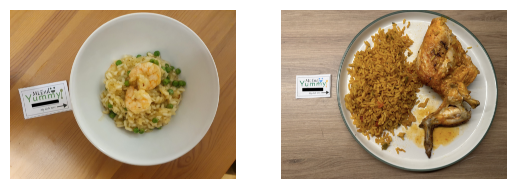

In [27]:
I = plt.imread(chips_or_rice_path[0])
plt.subplot(1,2,1)
plt.imshow(I)
plt.axis('off')

I = plt.imread(chips_or_rice_path[9])
plt.subplot(1,2,2)
plt.imshow(I)
plt.axis('off')
plt.show()

Train and test splitting:

In [28]:
#extracting the train dataset
train_set = chips_or_rice[chips_or_rice.Benchmark_A == "Train"]

#extracting the y for train
tr_y = [i for i in train_set.c_or_r]

#creating y encoded
tr_y_enc = [0 if i == "chips" else 1 for i in tr_y]

print(f"First 10 Train labels: ")
print(tr_y[:10], "\n")
print(f"First 10 Train labels encoded: ")
print(tr_y_enc[:10])

First 10 Train labels: 
['rice', 'rice', 'rice', 'chips', 'rice', 'chips', 'chips', 'rice', 'rice', 'chips'] 

First 10 Train labels encoded: 
[1, 1, 1, 0, 1, 0, 0, 1, 1, 0]


In [29]:
#extracting the test dataset
test_set = chips_or_rice[chips_or_rice.Benchmark_A == "Test"]

#extracting the y for test
ts_y = [i for i in test_set.c_or_r]

#creating y encoded
ts_y_enc = [0 if i == "chips" else 1 for i in ts_y]

print(f"First 10 Test labels: ")
print(ts_y[:10], "\n")
print(f"First 10 Test labels encoded: ")
print(ts_y_enc[:10])

First 10 Test labels: 
['rice', 'chips', 'chips', 'chips', 'chips', 'rice', 'chips', 'rice', 'chips', 'rice'] 

First 10 Test labels encoded: 
[1, 0, 0, 0, 0, 1, 0, 1, 0, 1]


In [30]:
#creating a list of train x paths
tr_xpath = [f"/content/drive/MyDrive/Data1/MLEnd1/yummy/MLEndYD_images/{path}" for path in list(train_set.index)]

#creating a list of test x paths
ts_xpath = [f"/content/drive/MyDrive/Data1/MLEnd1/yummy/MLEndYD_images/{path}" for path in list(test_set.index)]

Let's have a look at some of the images of chips and some of rice, this should re-ensure us about the quality of our updated dataset.

Rice


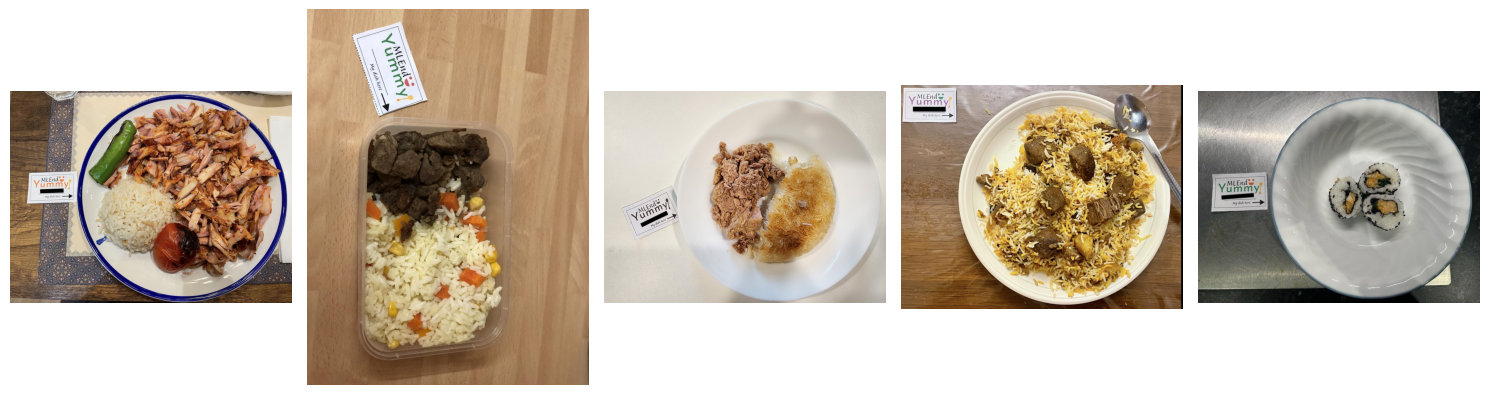

Chips


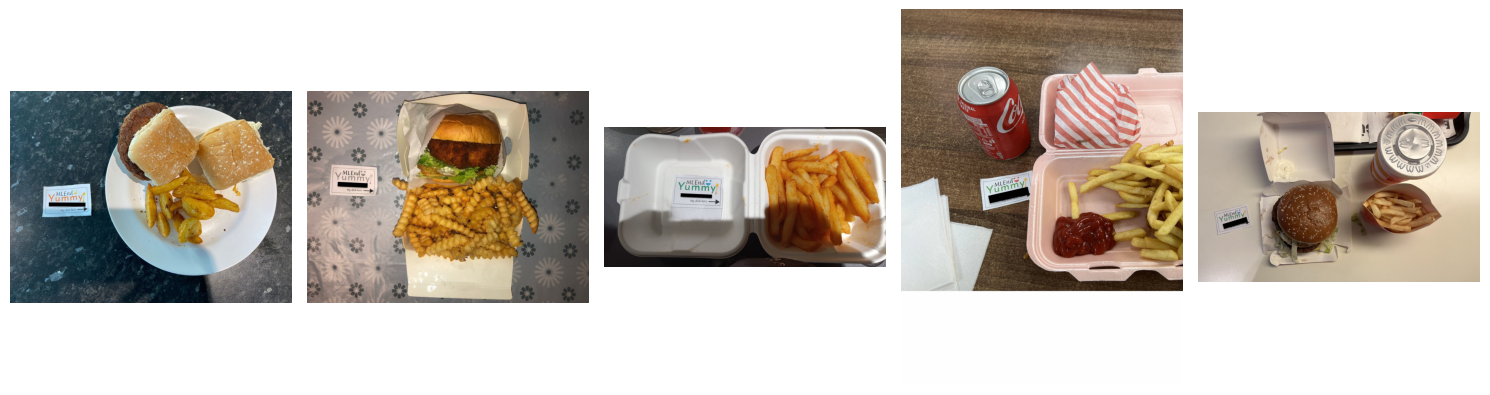

In [31]:
Chips_Img = np.array(tr_xpath)[np.array(tr_y_enc)==0]
Rice_Img = np.array(ts_xpath)[np.array(ts_y_enc)==1]

print('Rice')
plt.figure(figsize=(15,5))
for k,file in enumerate(Rice_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

print('Chips')
plt.figure(figsize=(15,5))
for k,file in enumerate(Chips_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

Shushi still has rice in it and it is clearly visible in the image, I didn't exclude it's index to make it more challenging and realistic.

### Function to pre-process the image: make_it_square and resize_img
1. Padding the image equally on both sides of the shorter dimension instead of padding it just on just one side of the shorter dimension like we did in the lab. Reasons and possible explanaitons:
    * This was the first change that I made to the entire pipline and this change alone made my accuracy go up from 0.53 to 0.6202.
    * When you examine the area of intersection for the padded versions of a portrait image and a landscape image, in the equal padding case, it is the exact center of the image. In the case of uni-directional padding, the intersection is at the top-left corner. This may comment on how most people center their food in the frame when taking a picture.
1. Resizing: We keep the information preservation at 200 pixels x 200 pixels. Reasons and possible explanations:
    * Going down to 100x100 made us lose a lot of information and going up to 300x300 was becoming computationally expensive without making any change to the model's accuracy.

In [32]:
def make_it_square(I, pad=0):
    N, M, C = I.shape
    if N > M:
        Is = [np.pad(I[:,:,i], [(0,0),(0, (N-M)//2)], 'constant', constant_values=pad) for i in range(C)]
        Is2 = [np.pad(Is[i], [(0, 0), ((N-M)//2, 0)], 'constant', constant_values=pad) for i in range(C)]
    else:
        Is = [np.pad(I[:,:,i], [(0, (M-N)//2),(0, 0)], 'constant', constant_values=pad) for i in range(C)]
        Is2 = [np.pad(Is[i], [((M-N)//2, 0),(0, 0)], 'constant', constant_values=pad) for i in range(C)]

    return np.array(Is2).transpose([1, 2, 0])

def resize_img(I,size=[100,100]):
  N,M,C = I.shape
  Ir = [sp.core.processing.resize(I[:,:,i],size) for i in range(C)]
  return np.array(Ir).transpose([1,2,0])

### The dreadful step:
It will take some 10 to 15 minutes, or even 20.

In [33]:
X_train = []
for k,file in enumerate(tr_xpath):
  sp.utils.ProgBar_JL(k,len(tr_xpath),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_train.append(I)

X_test = []
for k,file in enumerate(ts_xpath):
  sp.utils.ProgBar_JL(k,len(ts_xpath),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_test.append(I)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_train.shape, X_test.shape

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|182\182|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|80\80|
Done!


((182, 200, 200, 3), (80, 200, 200, 3))

Let's now plot a few images after resizing:

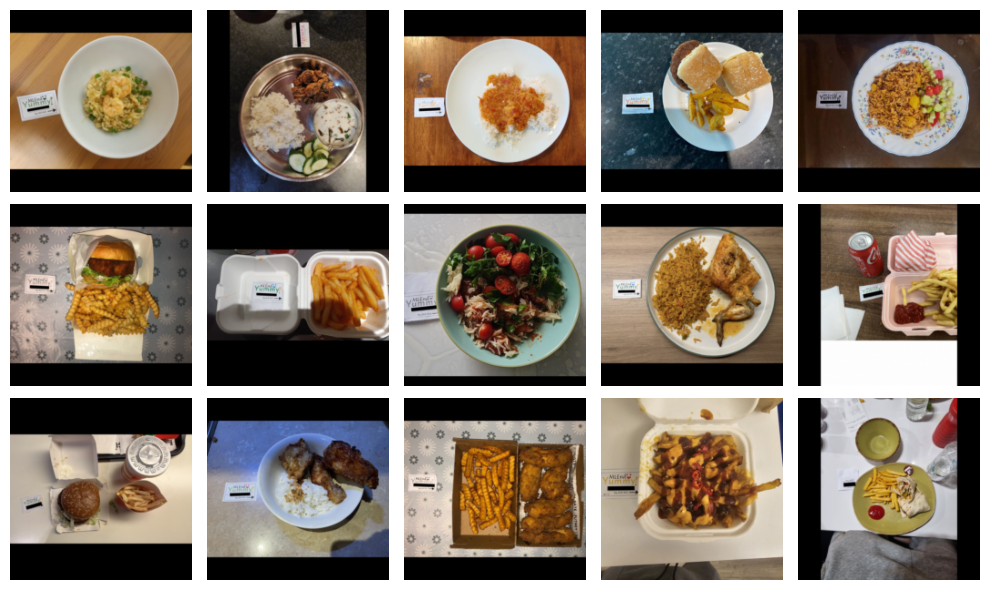

In [34]:
plt.figure(figsize=(10,6))
for k,I in enumerate(X_train):
  plt.subplot(3,5,k+1)
  plt.imshow(I)
  plt.axis('off')
  k+=1
  if k>=15:break
plt.tight_layout()
plt.show()

### Confusion matrix funtion:

In [35]:
def showConfMat(CM, labels = ['Chips','Rice']):
  plt.matshow(CM,cmap='Blues')
  for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
      plt.text(i,j,CM[i,j].round(2),ha='center',)
  plt.xticks([0,1],labels)
  plt.yticks([0,1],labels)
  plt.show()

### Feature 1: get_yellow_component()
A feature that uses a mask to get the yellow component. Reasons and possible explnations:
  * Any image with fries "should ideally have" higher yellow component.<br>
  Comments:
  * Needs further fine tuning.

In [36]:
from skimage.feature import ORB
from skimage.feature import graycomatrix, graycoprops

In [37]:
def get_yellow_component(I,t1=27, t2=33):
    """
     A feature that uses a mask to get the yellow component.

    parameters:
    - Image, t1, t1 (Hue thresholds defining the yellow range in the hsv color space)

    returns:
    - number of yellow pixels in the image
    """

    Ihsv = (rgb2hsv(I)*255).astype('uint8')
    mask = (Ihsv[:,:,0]<t2)*(Ihsv[:,:,0]>t1)
    Ypx = mask.sum()
    return Ypx

### Feature 2: (Existing features and new) GLCM_features()
  1. Dissimilarity: A measure that the averages absolute difference in intensity between a pixel and its neighbor for all pixel pairs in the image. Reason and possible explanation:
      * Possibility of being low for rice and high for fries because pictures with rice may have low overall difference in pixel pair intensity.<br>
  Comments:
      * Might only work for ideal zoomed in pictures with low or no noise
  1. Correlation: A measure for linear dependency between the grayscale values of neighboring pixels in the image. Reasons and possible explanation:
      * Possibility of being high for rice and low for fries because pictures with rice may have high overall linear dependency between neighboring pixels in the image.<br>
  Comments:
      * Might only work for ideal zoomed in pictures with low or no noise
  1. Energy: A measure for uniformity or homogeneity of the image texture. It is the sum of squared elements in the GLCM. Reasons and possible explanations:
      * Higher tendency for the texture to be more uniform or consistent between pixel pairs for rice, leading to a higher energy value, in contrast to images of fries.<br>
  Comments:
      * Might only work for ideal zoomed in pictures with low or no noise
  1. Entropy: A measure that quantifies the randomness or disorder in the spatial distribution of pixel pairs with different intensity values. Reasons and possible explanations:
      * Possibility of being high for fries and low for rice because pictures with fries may have high overall randomness or disorder betweeen pixels pairs in the image.<br>
  Comments:
      * Might only work for ideal zoomed in pictures with low or no noise

In [38]:
def GMLC_features(I):
    """
    extracts texture features from a grayscale image using GLCM

    Parameters:
    - I: input image in RGB format.

    Returns:
    - f1: dissimilarity feature.
    - f2: correlation feature.
    - f3: energy feature.
    - f4: entropy feature.
    """
    Ig = (rgb2gray(I)*255).astype('uint8')
    glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    f1 = graycoprops(glcm, 'dissimilarity')[0, 0]
    f2 = graycoprops(glcm, 'correlation')[0, 0]
    f3 = graycoprops(glcm, 'energy')[0, 0] #addition of new feature energy
    f4 = -np.sum(glcm * np.log2(glcm + (glcm == 0))) #addition of new feature entropy
    return f1,f2,f3,f4

### Feature 3: edge_density()
The function calculates the edge density of an input image using the Canny edge detector. Reasons and possible explanation:
  * Fries should have a higher number of strong edges and thus a higher edge density. <br>
  Comments:
  * It works well but not well enough. I feel that there is no scope of further development.

In [39]:
from skimage import feature, color

In [40]:
def edge_density(image):
    """
    calculates the edge density of an image using the canny edge detector

    Parameters:
    - image: input image in RGB format

    Returns:
    - edge_density_value: ratio of edge pixels to total pixels
    """
    #converting the image to grayscale and ensuring it's still in "uint8" format
    gray_image = (color.rgb2gray(image)*255)#.astype("uint8")

    #applying canny edge detector
    edges = feature.canny(gray_image)

    #calculating edge density as the ratio of edge pixels to total pixels
    edge_density_value = edges.sum() / float(edges.size)

    return edge_density_value

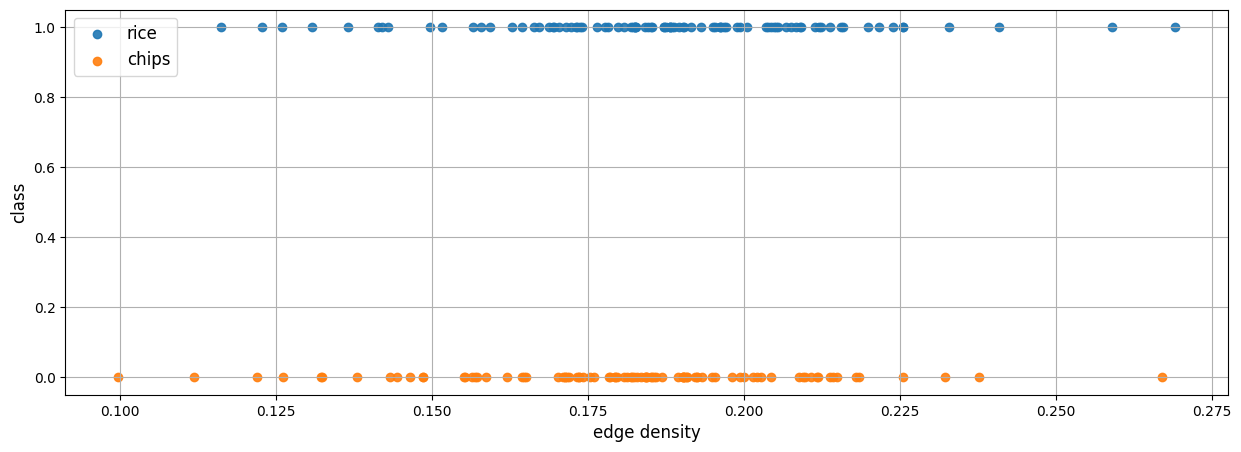

In [41]:
#scatter plot for better visualization
edge_density_list = [edge_density(image) for image in X_train]
chips_class = [i == "chips" for i in train_set.c_or_r]
rice_class = [i == "rice" for i in train_set.c_or_r]
chips_edge_density = np.array(edge_density_list)[chips_class]
rice_edge_density = np.array(edge_density_list)[rice_class]
plt.figure(figsize = (15, 5))
plt.scatter(rice_edge_density, np.ones(shape = rice_edge_density.shape), alpha = 0.9, label = "rice")
plt.scatter(chips_edge_density, np.zeros(shape = chips_edge_density.shape), alpha = 0.9, label = "chips")
plt.xlabel("edge density", fontsize = 12)
plt.ylabel("class", fontsize = 12)
plt.grid(True)
plt.legend(fontsize = 12)
plt.show()

### Feature 4: mser_features():
1. Total number of regions: A feature that quantifies the number of Maximally Stable Extremal Regions (MSER) in an input image using OpenCV's MSER detector. Reasons and possible explanations:
    * Detects little grains of rice that are seen to be stably distributed in the image.<br>
Comments:
    * Needs tuning such that it skips out noisy regions. Huge potential for further development. Works well for rice.
1. get_iou_features: function calculates the number of Intersection over Union (IoU) values for pairs of Maximally Stable Extremal Regions (MSER) with the same size detected in the input image. Reason and possible explanations:
    * It was later added to the function as further development to the the previous feature such that it only counts and compares regions of same size.<br>
Comments:
    * Did not prove out to be as effective as imagined. Still requires further development.

In [42]:
def calculate_iou(region1, region2):
    """
    'tries' to calculate intersection over union between two regions

    parameters:
    - region1, region2: numpy arrays representing the coordinates of regions.

    returns:
    - iou value
    we are basically trying to calcuate how identical two regions with the same shape are
    try and except is for cases where the regions are of different sizes, in which case none will be returned.
    """
    try:
      intersection = np.logical_and(region1, region2)
      union = np.logical_or(region1, region2)
      iou = np.sum(intersection) / np.sum(union)
      return iou
    except:
      pass


def mser_features(image):
    """
    calculates the number of maximally stable extremal regions (MSER) in an image
    and counts the number of similar regions based on their intersection over union (IoU)

    Parameters:
    - image: image array in uint8 format

    Returns:
    - total number of MSER regions.
    - number of similar regions based on IoU
    """
    #ensureing the image is in uint8 format
    image = (image * 255).astype('uint8')

    #converting the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    #creating MSER object
    mser = cv2.MSER_create()

    #detecting MSER regions
    regions, _ = mser.detectRegions(gray_image)
    regions_filtered = [i for i in regions if i.size <= 500]

    filtered_regions = [region for region in regions if region.size <= 2000]
    # filtered_regions = [region.size for region in regions]


    iou_values = []
    for i, region1 in enumerate(regions):
        for j, region2 in enumerate(regions):
            if i != j:  #this is to avoid comparing the same regions
                iou = calculate_iou(region1, region2)
                if iou == None: #when region 1 and region 2 are of different size None will be returned
                  continue
                iou_values.append(iou)
    similar_regions = len(iou_values)

    #returning the number of regions
    return (len(regions_filtered), similar_regions)

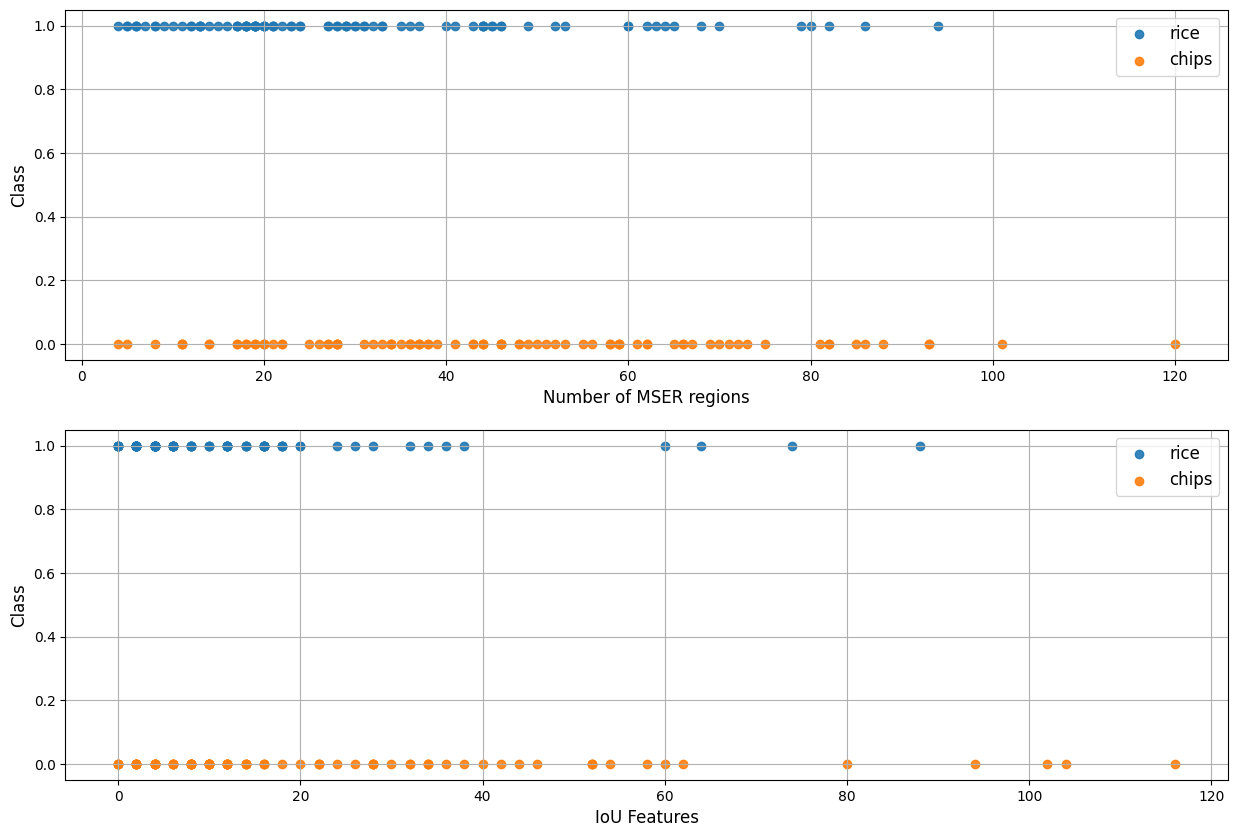

In [43]:
mser_features_list = [mser_features(image) for image in X_train]

#creating mask
chips_class = [i == "chips" for i in train_set.c_or_r]
rice_class = [i == "rice" for i in train_set.c_or_r]

#calculating feature and applying mask
get_number_of_regions_list = [i[0] for i in mser_features_list]
chips_get_number_of_regions = np.array(get_number_of_regions_list)[chips_class]
rice_get_number_of_regions = np.array(get_number_of_regions_list)[rice_class]

#calculating feature and applying mask
get_iou_features_list = [i[1] for i in mser_features_list]
chips_get_iou_features = np.array(get_iou_features_list)[chips_class]
rice_get_iou_features = np.array(get_iou_features_list)[rice_class]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

#scatter plot for number of MSER regions
ax1.scatter(rice_get_number_of_regions, np.ones(shape=rice_get_number_of_regions.shape), alpha=0.9, label="rice")
ax1.scatter(chips_get_number_of_regions, np.zeros(shape=chips_get_number_of_regions.shape), alpha=0.9, label="chips")
ax1.set_xlabel("Number of MSER regions", fontsize=12)
ax1.set_ylabel("Class", fontsize=12)
ax1.grid(True)
ax1.legend(fontsize=12)

#scatter plot for IoU features
ax2.scatter(rice_get_iou_features, np.ones(shape=rice_get_iou_features.shape), alpha=0.9, label="rice")
ax2.scatter(chips_get_iou_features, np.zeros(shape=chips_get_iou_features.shape), alpha=0.9, label="chips")
ax2.set_xlabel("IoU Features", fontsize=12)
ax2.set_ylabel("Class", fontsize=12)
ax2.grid(True)
ax2.legend(fontsize=12)

plt.show()

### Feature 5: get_yellowness_scores()
Another vain attempt to capture the "yellowness" inside images by first applying a mask on the hsv and then calculating the frequency of yellow pixels in the image. Reasons and possible explanations:
  * On an average the frequency of yellow pixels for images with fries "should ideally" be high.<br>
Comment:
  * Isn't well thought out. Disregards pictures where there are fewer number of fries and pictures where rice has a yellow color.

In [44]:
#trying to formulate a better get yellow component feature
"""
here instead of using the entire image we create a mask such that only the yellow region in
the given region is preserved and calculate "yellowness" score
"""
def calculate_yellowness_scores(image):
    """
    creates a mask to isolate yellow regions and calculates the "yellowness" score

    Parameters:
    - image: input image in rgb format

    Returns:
    - yellowness_score1: yellowness score (frequency of yellow pixels)
    """
    hsv = (rgb2hsv(image)*255).astype("uint8")

    #defining the lower and upper bounds for the yellow color
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    #creating a mask using the inRange function
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    #calculating the yellowness score (percentage of yellow pixels)
    total_pixels = np.prod(image.shape[:2])  # Total number of pixels in the image
    yellow_pixels = np.count_nonzero(yellow_mask)  # Number of yellow pixels
    yellowness_score1 = yellow_pixels / total_pixels #frequency of yellow pixels

    return yellowness_score1

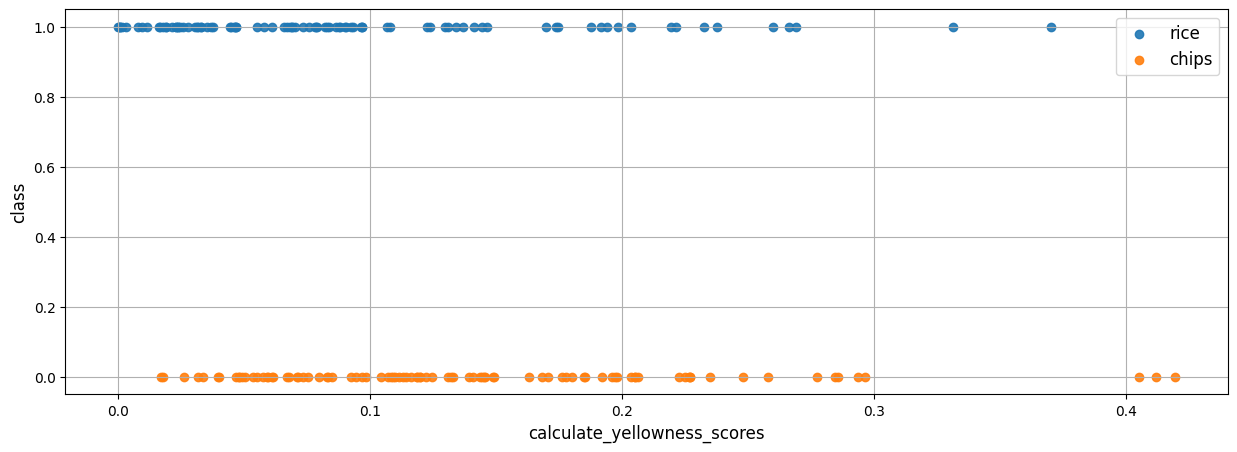

In [45]:
#scatter plot for better visualization
calculate_yellowness_scores_list = [calculate_yellowness_scores(image) for image in X_train]
chips_class = [i == "chips" for i in train_set.c_or_r]
rice_class = [i == "rice" for i in train_set.c_or_r]
chips_calculate_yellowness_scores = np.array(calculate_yellowness_scores_list)[chips_class]
rice_calculate_yellowness_scores = np.array(calculate_yellowness_scores_list)[rice_class]
plt.figure(figsize = (15, 5))
plt.scatter(rice_calculate_yellowness_scores, np.ones(shape = rice_calculate_yellowness_scores.shape), alpha = 0.9, label = "rice")
plt.scatter(chips_calculate_yellowness_scores, np.zeros(shape = chips_calculate_yellowness_scores.shape), alpha = 0.9, label = "chips")
plt.xlabel("calculate_yellowness_scores", fontsize = 12)
plt.ylabel("class", fontsize = 12)
plt.grid(True)
plt.legend(fontsize = 12)
plt.show()

### Feature 6: calculate_yellow_mser_regions()
Function built as a combination two of the features above in an attempt to capture mser regions after applying the mask on hsv to get only yellow mse regions. Reasons and possible explanationss:
  * That would help block out noise from colors that are other than some shade of yellow, thus capturing yellow mse regions, so to speak.<br>
Comment:
  * Made sense in theory but not so much in practice. It still doesn't address rice that may be yellow in color, which happens frequently.

In [46]:
def calculate_yellow_mser_regions(image):
    """
    counts the number of maximally stable extremal regions (MSER) in the yellow regions of the image

    Parameters:
    - image: input image in rgb format

    Returns:
    - num_regions: number of MSER regions in the yellow regions
    """

    image = (image * 255).astype('uint8')

    # Convert the image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define the lower and upper bounds for the yellow color
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Create a mask using the inRange function
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Apply MSER on the yellow mask
    mser = cv2.MSER_create()
    regions, _ = mser.detectRegions(yellow_mask)

    # Get the number of regions detected by MSER
    num_regions = len(regions)

    return num_regions

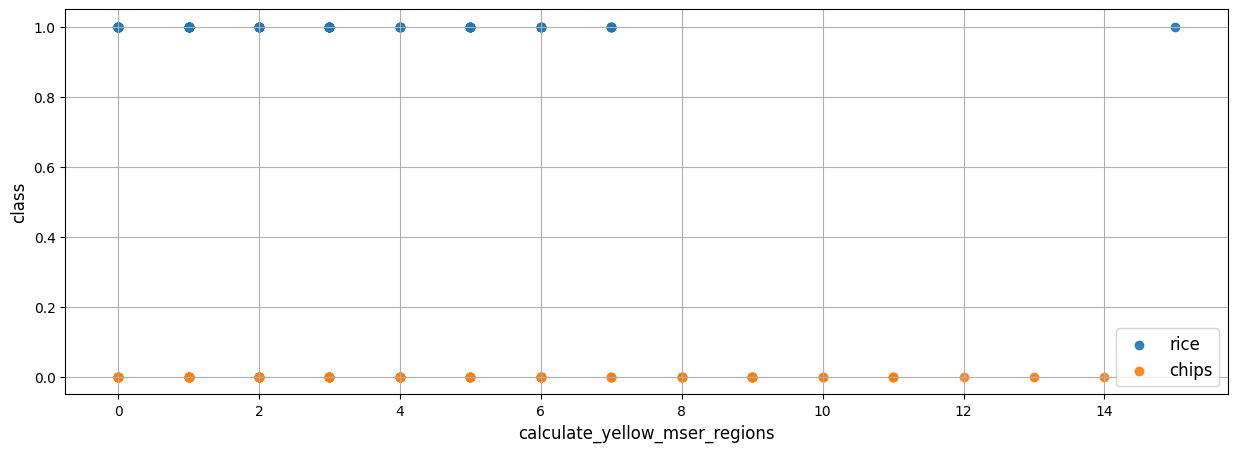

In [47]:
#scatter plot for better visualization
calculate_yellow_mser_regions_list = [calculate_yellow_mser_regions(image) for image in X_train]
chips_class = [i == "chips" for i in train_set.c_or_r]
rice_class = [i == "rice" for i in train_set.c_or_r]
chips_calculate_yellow_mser_regions = np.array(calculate_yellow_mser_regions_list)[chips_class]
rice_calculate_yellow_mser_regions = np.array(calculate_yellow_mser_regions_list)[rice_class]
plt.figure(figsize = (15, 5))
plt.scatter(rice_calculate_yellow_mser_regions, np.ones(shape = rice_calculate_yellow_mser_regions.shape), alpha = 0.9, label = "rice")
plt.scatter(chips_calculate_yellow_mser_regions, np.zeros(shape = chips_calculate_yellow_mser_regions.shape), alpha = 0.9, label = "chips")
plt.xlabel("calculate_yellow_mser_regions", fontsize = 12)
plt.ylabel("class", fontsize = 12)
plt.grid(True)
plt.legend(fontsize = 12)
plt.show()

### Feature 7: corner_count()
A feature that quantifies the normalized density of corners in an image using the Harris corner detector. Reasons and possible explanations:
  * A picture with fries should have an unusually high number of corners. <br>
Comments:
  * Works well for fries. First of a kind in the above list of features. Huge potential for further developments like ignoring smaller corners in the image so that the ones for rice are not caputured at all or atleast filtered out later.


In [48]:
from skimage.feature import corner_harris

In [49]:
def corner_count(image):
    """
    calculates the normalized count of corners in an image using the harris corner detector

    Parameters:
    - image: input image in rgb format

    Returns:
    - corner_count_value: normalized count of corners.
    """
    # Converting the image to grayscale and ensuring it's still in "uint8" format
    gray_image = (color.rgb2gray(image) * 255).astype("uint8")

    # Applying Harris corner detector
    corners = corner_harris(gray_image)

    # Counting the number of corners (non-zero elements in the corner response)
    corner_count_value = np.count_nonzero(corners) / float(gray_image.size)

    return corner_count_value

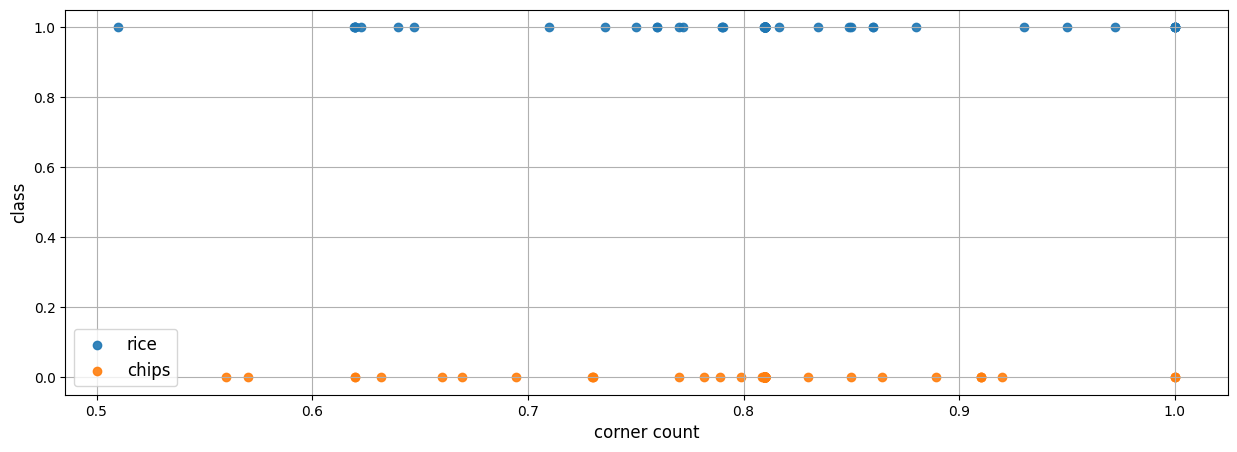

In [50]:
#scatter plot for better visualization
corner_count_list = [corner_count(image) for image in X_train]
chips_class = [i == "chips" for i in train_set.c_or_r]
rice_class = [i == "rice" for i in train_set.c_or_r]
chips_corner_count = np.array(corner_count_list)[chips_class]
rice_corner_count = np.array(corner_count_list)[rice_class]
plt.figure(figsize = (15, 5))
plt.scatter(rice_corner_count, np.ones(shape = rice_corner_count.shape), alpha = 0.9, label = "rice")
plt.scatter(chips_corner_count, np.zeros(shape = chips_corner_count.shape), alpha = 0.9, label = "chips")
plt.xlabel("corner count", fontsize = 12)
plt.ylabel("class", fontsize = 12)
plt.grid(True)
plt.legend(fontsize = 12)
plt.show()

In most of the cases above, the features for rice and chips seem to overlap in the scatter plot due to the shared attributes such as color, texture, and shape that can be common between them. When visually inspected, they may exhibit similar characteristics, leading to overlapping feature representations. Despite this overlap, exploring these features is still valuable as subtle differences might exist in the finer details or patterns that are not immediately apparent. By investigating a comprehensive set of features, the classifier has the potential to identify subtle differences, contributing to improved accuracy in distinguishing between rice and chips in diverse scenarios.

# 8 Results
Let us now extract the features from each image and create the transform sets `X_train_f` and `X_test_f`:<br>
We will compute all sorts of features but only use the one that makes the most sense. After experimenting with a lot of combination, I have decided to only use yellow mser regions feature because it was one of the very rare features that had a balanced precision and recall, meaning it was capturing the charateristics of both rice and chips well as opposed to just one of them.

In [51]:
print(X_train.shape)

(182, 200, 200, 3)


In [52]:
X_train_f = []
for k, I in enumerate(X_train):
  f1 = get_yellow_component(I)
  f2,f3,f4,f5 = GMLC_features(I)
  f6 = edge_density(I)
  f7, f8 = mser_features(I)
  f9 = calculate_yellowness_scores(I)
  f10 = calculate_yellow_mser_regions(I)
  f11 = corner_count(I)
  X_train_f.append([f10])

X_test_f = []
for k, I in enumerate(X_test):
  f1 = get_yellow_component(I)
  f2,f3,f4,f5 = GMLC_features(I)
  f6 = edge_density(I)
  f7, f8 = mser_features(I)
  f9 = calculate_yellowness_scores(I)
  f10 = calculate_yellow_mser_regions(I)
  f11 = corner_count(I)
  X_test_f.append([f10])

After formatting both `X_train_f` and `X_test_f` as numpy arrays, we can check their respective shapes:

In [53]:
X_train_f = np.array(X_train_f)
X_test_f = np.array(X_test_f)
X_train_f.shape, X_test_f.shape

((182, 1), (80, 1))

## Normalization
In addition to reducing the dimensionality of the prediction space, let's implement a normalisation stage to ensure that the attributes in the new prediction space take on a similar range of values. We will implement standardisation.

In [54]:
MEAN = X_train_f.mean(0)
SD = X_train_f.std(0)

X_train_fn = (X_train_f - MEAN)/SD
X_test_fn = (X_test_f - MEAN)/SD

## Model
* I experimented with various models, including Logistic Regression, K-Nearest Neighbors, Naive Bayes, Decision Tree, Multi-layer Perceptron, and Random Forest. Logistic Regression struggled with capturing complex relationships, K-Nearest Neighbors was computationally expensive and lacked feature relevance capture, and Naive Bayes faced challenges due to its assumption of independence amongst features. Decision Tree showed overfitting tendencies, demonstrating it by achieving high training accuracy but low testing accuracy, and Random Forest exhibited similar issues.

* After careful evaluation, I chose LinearSVC as my final model for several reasons. It effectively addressed class imbalances, demonstrated easy implementation, and was proficient in separating linearly separable features. Notably, it yielded the highest test accuracy among the models considered, making it the optimal choice for my predictive task.

The following are the models I experimented around with:

In [55]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.tree import DecisionTreeClassifier
# from lightgbm import LGBMClassifier

# #logistic regression
# model = LogisticRegression()
# model.fit(X_train_fn, tr_y_enc)

# #k-nearest neighbors
# model = KNeighborsClassifier()
# model.fit(X_train_fn, tr_y_enc)

# #naive bayes
# model = GaussianNB()
# model.fit(X_train_fn, tr_y_enc)

# #decision tree
# model = DecisionTreeClassifier()
# model.fit(X_train_fn, tr_y_enc)

# #multi-layer perceptron (neural network)
# model = MLPClassifier(max_iter = 100000)
# model.fit(X_train_fn, tr_y_enc)

# #random forest
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(n_estimators=5, max_depth=3)
# model.fit(X_train_fn, tr_y_enc)

'\nThe following are the models i experimented around with.\n'

In [56]:
#linearsvc classifier
from sklearn.svm import LinearSVC
model = LinearSVC(max_iter = 10000, class_weight = "balanced")
model.fit(X_train_fn, tr_y_enc)

LinearSVC(class_weight='balanced', max_iter=10000)

Now, let's use this trained model to predict the labels in the training and test datasets and based on the predicted labels, let's calculate the training and test accuracy:

### Model evaluation:

In [57]:
ytp = model.predict(X_train_fn)
ysp = model.predict(X_test_fn)

train_accuracy = np.mean(ytp==tr_y_enc)
test_accuracy  = np.mean(ysp==ts_y_enc)

print('Training Accuracy:\t',train_accuracy)
print('Test  Accuracy:\t',test_accuracy)

Training Accuracy:	 0.6538461538461539
Test  Accuracy:	 0.7625


It is safe to say that our model and choice of features is structured well enough to be able to generalise well for unseen test data, thus explaining why we would see a low training accuracy but high test accuracy.

### Counfusion matrix:

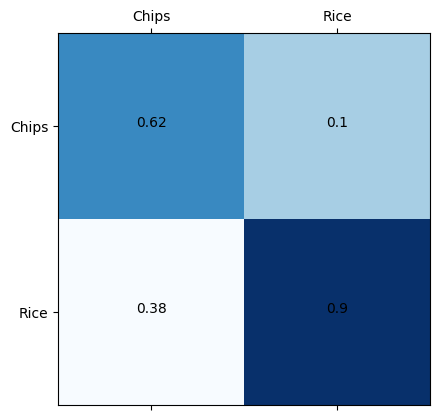

In [58]:
Ac = np.mean(ysp[np.array(ts_y_enc).astype(int)==0]==0)
Ar = np.mean(ysp[np.array(ts_y_enc).astype(int)==1]==1)

Mc = np.mean(ysp[np.array(ts_y_enc).astype(int)==0]==1)
Mr = np.mean(ysp[np.array(ts_y_enc).astype(int)==1]==0)

CM = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(CM)

Reiterating what I mentioned earlier, the confusion matrix provides insights into how well our model is performing for both classes in a balanced dataset, rather than focusing solely on one class. It is the reflected in the balance we see higher true positives and true negatives and lower false positives and false negatives. If the values above aren't clear, let's get a clear understaning using precison, recall and f1-score.

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#metrics for test
print(f"train prediction scores:")
#calculating accuracy
accuracy = accuracy_score(tr_y_enc, ytp)
print(f'Accuracy: {accuracy:.4f}')
#calculating precision
precision = precision_score(tr_y_enc, ytp, average = "weighted")
print(f'Precision: {precision:.4f}')
#calculating recall
recall = recall_score(tr_y_enc, ytp, average = "weighted")
print(f'Recall: {recall:.4f}')
#calculating f1 score
f1 = f1_score(tr_y_enc, ytp, average = "weighted")
print(f'F1 Score: {f1:.4f}')
print("-x"*20, "\n")

#metrics for test
print(f"test prediction scores:")
#calculating accuracy
accuracy = accuracy_score(ts_y_enc, ysp)
print(f'Accuracy: {accuracy:.4f}')
#calculating precision
precision = precision_score(ts_y_enc, ysp, average = "weighted")
print(f'Precision: {precision:.4f}')
#calculating recall
recall = recall_score(ts_y_enc, ysp, average = "weighted")
print(f'Recall: {recall:.4f}')
#calculating f1 score
f1 = f1_score(ts_y_enc, ysp, average = "weighted")
print(f'F1 Score: {f1:.4f}')
print("-x"*20)


train prediction scores:
Accuracy: 0.6538
Precision: 0.6625
Recall: 0.6538
F1 Score: 0.6492
-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x 

test prediction scores:
Accuracy: 0.7625
Precision: 0.7840
Recall: 0.7625
F1 Score: 0.7579
-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x


My model consistently maintains a balanced performance, evident in both training and testing phases. I deliberately addressed class imbalance and implemented a 70-30 training split, which can be a challenging ratio. The accuracy for training is now around 65.38%, with precision and recall closely aligned at 66.25% and 65.38%. Similarly, the test set demonstrates an accuracy of 76.25%, with precision and recall mirroring each other at 78.40% and 76.25%. This balance reflects on the model's ability to make positive predictions while avoiding excess false positives, resulting in an overall reliable performance. The F1 scores, considering both precision and recall, are also notably high in both training and testing, with an F1 Score of 64.92% for training and 75.79% for testing. This balanced approach suggests the model effectively balances the trade-off between minimizing false positives and capturing true positive instances, thus suitable for situations where such equilibrium is crucial.

### IMPORTANT NOTE
The "pipeline" below is not the "machine learing pipline", it is a coding language pipeline. It was only experimented with in an attempt to wrap up all the things we did above. My machine learning pipeline was what we saw in the notebook up until this point. The only difference is in the normalization step, we have not included it in the "coding pipeline" below because it would be incorrect to use the mean and std of test set for normalization and in case of just one image, it would throw an error. <br>
Let's now implement a dummy pipline that can take an image PATH and return a prediction. To do that we will first wrap the image processing and feature creation in two differents function, which will then be wrapped in a class to be included into our pipline.

In [60]:
"""
resize image and make it square functions remain the same
we will will just wrap them inside a function
"""

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer

def process_image(file_path):
    I = plt.imread(file_path)
    I = make_it_square(I, pad=0)
    I = resize_img(I, size=[200, 200])
    return I

def feature_creation(data):
    X_train_f = []
    for k, I in enumerate(data):
        # f1 = get_yellow_component(I)
        # f2,f3,f4,f5 = GMLC_features(I)
        # f6 = edge_density(I)
        # f7, f8 = mser_features(I)
        # f9 = calculate_yellowness_scores(I)
        f10 = calculate_yellow_mser_regions(I)
        # f11 = corner_count(I)
        X_train_f.append([f10])
    return np.array(X_train_f)

pre_process_image = FunctionTransformer(func = lambda X: np.array([process_image(file) for file in tqdm(X, desc = "Processing Images")]))
create_feature = FunctionTransformer(feature_creation)

#creating a pipeline that will take list of image paths as inputs
pipeline = Pipeline([
    ("pre_process_image", pre_process_image),
    ("extracting_feature", create_feature),
    ("model", LinearSVC(max_iter = 10000, class_weight = "balanced"))
])

Let's take this pipline out for a spin on a relatively smaller data set.

In [61]:
import random

#generating random indices that can be used to extract train paths and their respective true classes
train_indices = random.sample(range(len(tr_xpath)), 70)

#generating random indices that can be used to extract test paths and their respective true classes
test_indices = random.sample([i for i in range(len(ts_xpath)) if i not in train_indices], 30)

#extracting train paths and their true classes
train_xpaths = [tr_xpath[i] for i in train_indices]
test_xpaths = [ts_xpath[i] for i in test_indices]

#extracting test paths and their true classes
train_y_enc = [tr_y_enc[i] for i in train_indices]
test_y_enc = [ts_y_enc[i] for i in test_indices]

pipeline.fit(train_xpaths, train_y_enc)

Processing Images: 100%|██████████| 70/70 [02:26<00:00,  2.09s/it]


Pipeline(steps=[('pre_process_image',
                 FunctionTransformer(func=<function <lambda> at 0x78d14b583130>)),
                ('extracting_feature',
                 FunctionTransformer(func=<function feature_creation at 0x78d14b580940>)),
                ('model', LinearSVC(class_weight='balanced', max_iter=10000))])

In [62]:
#using just one image for making a prediction
prediction = pipeline.predict([test_xpaths[0]])

print(f"\n\nThe model predicted: {'Rice' if prediction == 1 else 'Chips'}\nTrue class: {'Rice' if ts_y_enc[0] == 1 else 'Chips'}")
if prediction == ts_y_enc[0]:
    print("The model guessed it right!")
else:
    print("No worries, the model can get it right the next time!")

Processing Images: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]



The model predicted: Rice
True class: Rice
The model guessed it right!


# 9 Conclusions

As a conclusion I would say that I may have tried out a lot of features but failed to effectively fine tune even one of them. I haven't been able to fine tune any features that would recognise or capture some characteristic of chips and rice "effectively". My classifier also did much better with the smaller yummy datset compared to the one I procured above. The model accuracy was 75% for former with a balanced dataset. It could be a comment on the fact that the bigger dataset is a more realistic mix of images captured from different angles and conditions. <br>
Areas where the workflow could use further development:
1. Better image processing.
  * Idea 1: Cropping the image in such a way that only the part of image that has pixel variation above a set threshold is captured automatically. This croped image could be of any size, we could then add the padding as a second step.
  * Idea 2: Streaching the image out along the shorter dimension. It would be like increasing the information present inside the image, so to speak.
1. My current methodology takes a really long time to resize the image, I need to look into more efficient methods.
1. Further fine tuning features like:
  * MSER_regions
  * corner_count
1. Exploring other aspects of the image array to come up with new features. So far, I have experimented with texture, colour component and patterns. As an addition, I could also try exploring shape features and spatial arrangements.
1. I could optimize feature combinations to enhance the classifier's ability to distinguish between rice and chips more effectively.
1. A more exhaustive fine tuning of parameters of classifier
1. Using cross validation based approach to rule out any doubt about the effectiveness of the model.